In [1]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

# Load the dataset
df = pd.read_csv('Food_Delivery_Time_Prediction.csv')
print(df.head())
print("\nDataset shape:", df.shape)

  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)      1.57   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)     21.32   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)      6.95   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)     13.79   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)      6.72   

  Weather_Conditions Traffic_Conditions  Delivery_Person_Experience  \
0              Rainy             Medium                           4   
1             Cloudy             Medium                           8   
2              Snowy             Medium                           9   
3             Cloudy                Low                           2   
4              Rainy               High                           6   

  Order_Priority Order_Time Vehicle_Type  Restaurant_Rating  Customer_Rating  \
0         Medium  Afternoon          Car                4.1 

In [2]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())

# Handle missing values (if any)
# For this dataset, we'll assume there are no missing values based on the given data
# If there were missing values, we might use:
# df.fillna(method='ffill', inplace=True)  # or other imputation methods


Missing values in each column:
Order_ID                      0
Customer_Location             0
Restaurant_Location           0
Distance                      0
Weather_Conditions            0
Traffic_Conditions            0
Delivery_Person_Experience    0
Order_Priority                0
Order_Time                    0
Vehicle_Type                  0
Restaurant_Rating             0
Customer_Rating               0
Delivery_Time                 0
Order_Cost                    0
Tip_Amount                    0
dtype: int64


In [3]:
# Function to calculate distance using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Extract latitude and longitude from location strings
df['Customer_Lat'] = df['Customer_Location'].str.extract(r'\(([^,]+),')[0].astype(float)
df['Customer_Lon'] = df['Customer_Location'].str.extract(r',\s*([^)]+)')[0].astype(float)
df['Restaurant_Lat'] = df['Restaurant_Location'].str.extract(r'\(([^,]+),')[0].astype(float)
df['Restaurant_Lon'] = df['Restaurant_Location'].str.extract(r',\s*([^)]+)')[0].astype(float)

# Calculate distance
df['Calculated_Distance'] = df.apply(
    lambda row: haversine_distance(
        row['Customer_Lat'], row['Customer_Lon'],
        row['Restaurant_Lat'], row['Restaurant_Lon']
    ), axis=1
)

# Compare with existing Distance column
print("\nComparison of Distance columns:")
print(df[['Distance', 'Calculated_Distance']].head())


Comparison of Distance columns:
   Distance  Calculated_Distance
0      1.57           775.651198
1     21.32          1042.385597
2      6.95           476.220706
3     13.79           389.912629
4      6.72           806.505886


In [4]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Encode categorical features
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Time', 'Vehicle_Type', 'Order_Priority']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Create binary target variable (1 for delayed, 0 for fast)
# We'll define "Fast" as delivery time less than 30 minutes (you can adjust this threshold)
threshold = 30
df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > threshold else 0)

# Normalize continuous features
continuous_cols = ['Distance', 'Calculated_Distance', 'Delivery_Person_Experience', 
                   'Restaurant_Rating', 'Customer_Rating', 'Order_Cost', 'Tip_Amount']
scaler = MinMaxScaler()
df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

print("\nAfter preprocessing:")
print(df.head())


After preprocessing:
  Order_ID       Customer_Location     Restaurant_Location  Distance  \
0  ORD0001  (17.030479, 79.743077)  (12.358515, 85.100083)  0.043068   
1  ORD0002  (15.398319, 86.639122)  (14.174874, 77.025606)  0.853158   
2  ORD0003  (15.687342, 83.888808)  (19.594748, 82.048482)  0.263741   
3  ORD0004  (20.415599, 78.046984)  (16.915906, 78.278698)  0.544299   
4  ORD0005  (14.786904, 78.706532)  (15.206038, 86.203182)  0.254307   

   Weather_Conditions  Traffic_Conditions  Delivery_Person_Experience  \
0                   1                   2                    0.333333   
1                   0                   2                    0.777778   
2                   2                   2                    0.888889   
3                   0                   1                    0.111111   
4                   1                   0                    0.555556   

   Order_Priority  Order_Time  Vehicle_Type  ...  Customer_Rating  \
0               2           0        

In [10]:
from sklearn.model_selection import train_test_split

# Select features and target
features = ['Distance', 'Weather_Conditions', 'Traffic_Conditions', 
            'Delivery_Person_Experience', 'Order_Priority', 'Order_Time',
            'Vehicle_Type', 'Restaurant_Rating', 'Customer_Rating',
            'Order_Cost', 'Tip_Amount', 'Calculated_Distance']
X = df[features]
y = df['Delivery_Status']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)


Training set shape: (140, 12)
Testing set shape: (60, 12)


In [13]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, f1_score,
                           balanced_accuracy_score)

# Initialize and train Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Make predictions
y_pred_nb = nb_classifier.predict(X_test)
y_proba_nb = nb_classifier.predict_proba(X_test)[:, 1]  # Probabilities for ROC

# Evaluate performance
print("\nNaive Bayes Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))
print("Classification Report:\n", classification_report(y_test, y_pred_nb, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_nb))

# If the model is performing poorly, consider these options:
if len(np.unique(y_pred_nb)) < 2:
    print("\nWarning: Model is predicting only one class!")
    print("Possible solutions:")
    print("1. Check for severe class imbalance and consider resampling")
    print("2. Try different models like Random Forest or XGBoost")
    print("3. Perform more feature engineering")


Naive Bayes Classifier Performance:
Accuracy: 0.9
Balanced Accuracy: 0.5
Confusion Matrix:
 [[ 0  6]
 [ 0 54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.90      1.00      0.95        54

    accuracy                           0.90        60
   macro avg       0.45      0.50      0.47        60
weighted avg       0.81      0.90      0.85        60

F1 Score: 0.9473684210526315

Possible solutions:
1. Check for severe class imbalance and consider resampling
2. Try different models like Random Forest or XGBoost
3. Perform more feature engineering


In [16]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                           classification_report, f1_score,
                           balanced_accuracy_score, roc_auc_score)

# Check class distribution first
print("Class distribution in training set:")
print(y_train.value_counts())

# Hyperparameter tuning for KNN
param_grid = {'n_neighbors': range(1, 20)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Best parameters
best_k = grid_search.best_params_['n_neighbors']
print("\nBest K for KNN:", best_k)

# Train KNN with best K
knn_classifier = KNeighborsClassifier(n_neighbors=best_k)
knn_classifier.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn_classifier.predict(X_test)
y_proba_knn = knn_classifier.predict_proba(X_test)[:, 1]  # For ROC-AUC

# Evaluate performance
print("\nKNN Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_knn))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))
print("Classification Report:\n", classification_report(y_test, y_pred_knn, zero_division=0))
print("F1 Score:", f1_score(y_test, y_pred_knn))


Class distribution in training set:
Delivery_Status
1    120
0     20
Name: count, dtype: int64

Best K for KNN: 9

KNN Classifier Performance:
Accuracy: 0.9
Balanced Accuracy: 0.5
ROC-AUC Score: 0.5709876543209876
Confusion Matrix:
 [[ 0  6]
 [ 0 54]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.90      1.00      0.95        54

    accuracy                           0.90        60
   macro avg       0.45      0.50      0.47        60
weighted avg       0.81      0.90      0.85        60

F1 Score: 0.9473684210526315


In [17]:
from sklearn.tree import DecisionTreeClassifier

# Hyperparameter tuning for Decision Tree
param_grid = {
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Best parameters
best_params = grid_search.best_params_
print("\nBest parameters for Decision Tree:", best_params)

# Train Decision Tree with best parameters
dt_classifier = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)
dt_classifier.fit(X_train, y_train)

# Make predictions
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate performance
print("\nDecision Tree Classifier Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("F1 Score:", f1_score(y_test, y_pred_dt))


Best parameters for Decision Tree: {'max_depth': 5, 'min_samples_split': 2}

Decision Tree Classifier Performance:
Accuracy: 0.8833333333333333
Confusion Matrix:
 [[ 0  6]
 [ 1 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         6
           1       0.90      0.98      0.94        54

    accuracy                           0.88        60
   macro avg       0.45      0.49      0.47        60
weighted avg       0.81      0.88      0.84        60

F1 Score: 0.9380530973451328


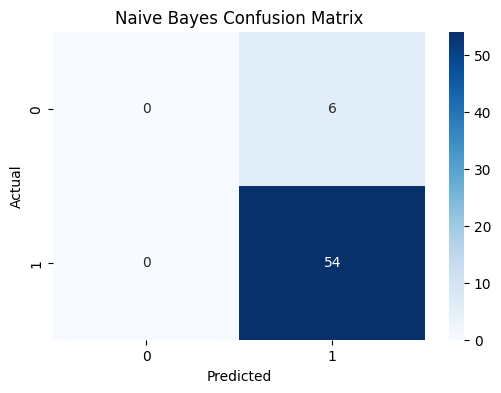

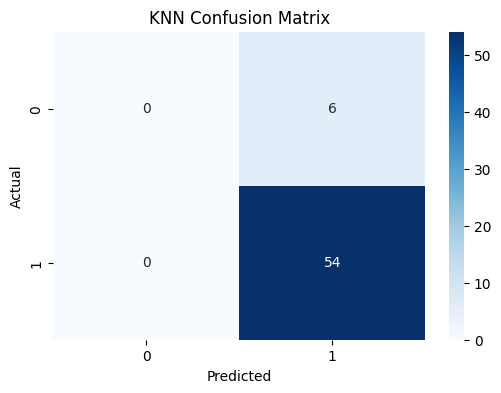

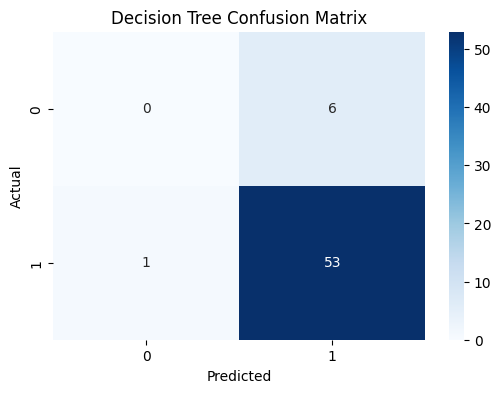

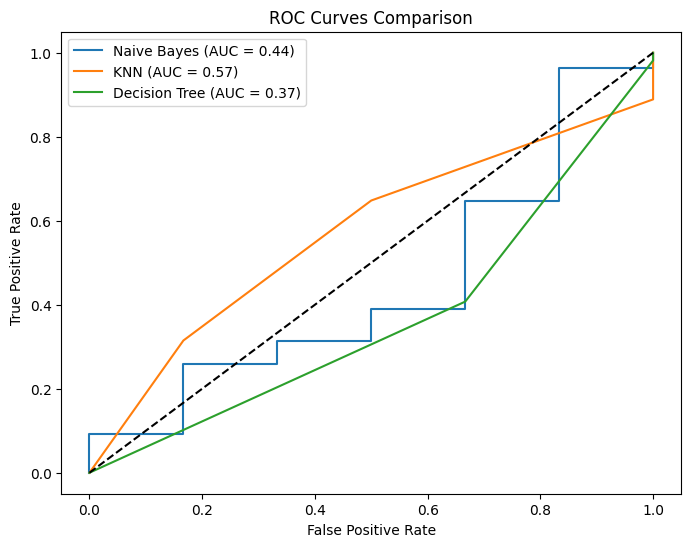

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(y_test, y_pred_nb, "Naive Bayes Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_knn, "KNN Confusion Matrix")
plot_confusion_matrix(y_test, y_pred_dt, "Decision Tree Confusion Matrix")

# Plot ROC curves
plt.figure(figsize=(8, 6))

# Naive Bayes ROC
fpr, tpr, _ = roc_curve(y_test, nb_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Naive Bayes (AUC = {roc_auc:.2f})')

# KNN ROC
fpr, tpr, _ = roc_curve(y_test, knn_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc:.2f})')

# Decision Tree ROC
fpr, tpr, _ = roc_curve(y_test, dt_classifier.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()

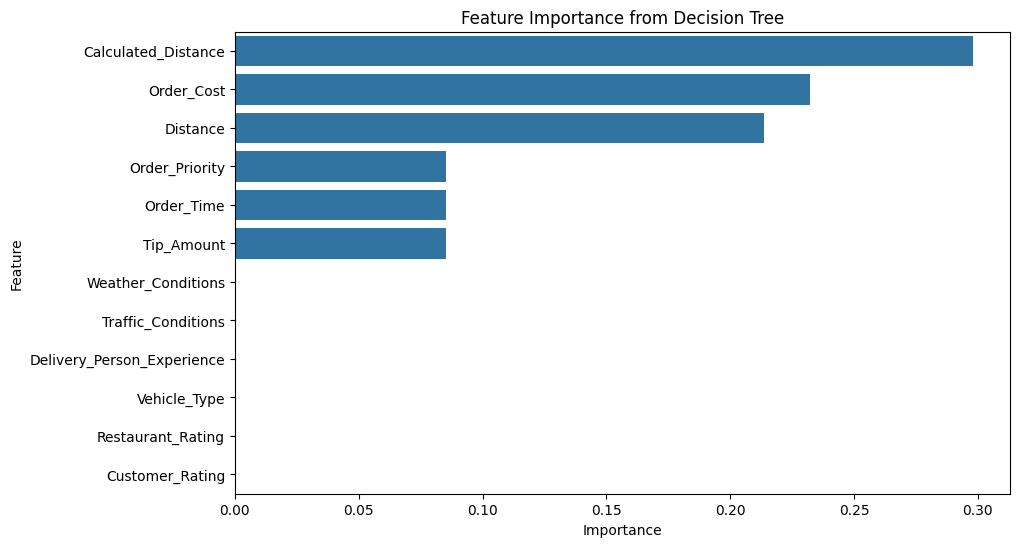


Feature Importance:
                       Feature  Importance
11         Calculated_Distance    0.298033
9                   Order_Cost    0.232062
0                     Distance    0.213807
4               Order_Priority    0.085366
5                   Order_Time    0.085366
10                  Tip_Amount    0.085366
1           Weather_Conditions    0.000000
2           Traffic_Conditions    0.000000
3   Delivery_Person_Experience    0.000000
6                 Vehicle_Type    0.000000
7            Restaurant_Rating    0.000000
8              Customer_Rating    0.000000


In [19]:
# Feature importance for Decision Tree
feature_importance = dt_classifier.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance from Decision Tree')
plt.show()

print("\nFeature Importance:")
print(feature_importance_df)


Model Comparison:
           Model  Accuracy  F1 Score
0    Naive Bayes  0.900000  0.947368
1            KNN  0.900000  0.947368
2  Decision Tree  0.883333  0.938053


<Figure size 1000x500 with 0 Axes>

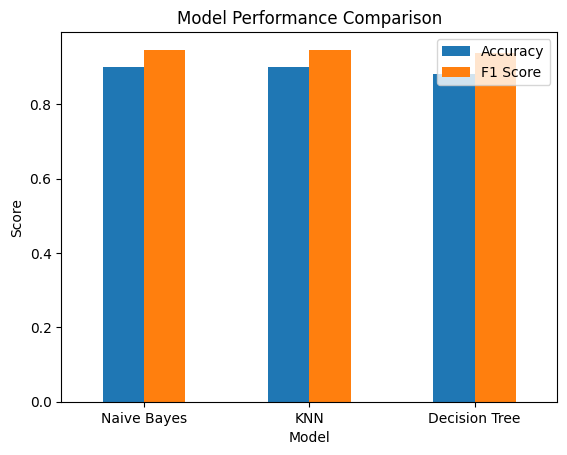


Best performing model: Naive Bayes


In [20]:
# Compare all models
models = {
    'Naive Bayes': nb_classifier,
    'KNN': knn_classifier,
    'Decision Tree': dt_classifier
}

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    results.append({'Model': name, 'Accuracy': accuracy, 'F1 Score': f1})

results_df = pd.DataFrame(results)
print("\nModel Comparison:")
print(results_df)

# Visualize model comparison
plt.figure(figsize=(10, 5))
results_df.set_index('Model').plot(kind='bar', rot=0)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.show()

# Based on the results, we can select the best performing model
best_model_name = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
best_model = models[best_model_name]
print(f"\nBest performing model: {best_model_name}")